In [1427]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [1428]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [1429]:
df = pd.read_sql_query("SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE (cast(t.completedDateTime as Date) = cast(getdate() as Date)) AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service')\
    ORDER BY completedDateTime DESC", cnxn)

In [1430]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 29 2022 11:34AM,15,"Alliance Pharma, Inc.",Picking,Karen Hernandez,11
1,Mar 29 2022 11:34AM,18,Hush Hush,Picking,Jose Rodriguez,11
2,Mar 29 2022 11:34AM,15,"Alliance Pharma, Inc.",Picking,Karen Hernandez,11
3,Mar 29 2022 11:33AM,15,"Alliance Pharma, Inc.",Picking,Karen Hernandez,11
4,Mar 29 2022 11:33AM,19,ACG North America LLC,Picking,Angel Luna,11


### Warehouse Activity

In [1431]:
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,216
1,102,21
2,12,39
3,15,126
4,16,144


In [1432]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [1433]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [1434]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,216
102,21
12,39
15,126
16,144


### All Operations type

In [1435]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,28
1,Count,47
2,Create Inventory,1
3,DONE RECEIVING,6
4,DRIVER CHECK IN,8


In [1436]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [1437]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,28
1,Count,47
2,Create Inventory,1
3,DONE RECEIVING,6
4,DRIVER CHECK IN,8


In [1438]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,28
Count,47
Create Inventory,1
DONE RECEIVING,6
DRIVER CHECK IN,8


### Excluding Operations PICKING and RECEIVING

In [1439]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [1440]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,28
Count,47
Create Inventory,1
DONE RECEIVING,6
DRIVER CHECK IN,8


### Operations per Hour

In [1441]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,8
1,7,45
2,8,288
3,9,379
4,10,376


In [1442]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [1443]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,8
7,45
8,288
9,379
10,376


# PICKING

In [1444]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [1445]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Angel Luna,8,4
1,Angel Luna,9,9
2,Angel Luna,10,5
3,Angel Luna,11,9
4,Angela Pena,9,45


In [1446]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11
employee,,,,,
Angel Luna,0.0,4.0,9.0,5.0,9.0
Angela Pena,0.0,0.0,45.0,0.0,0.0
Brad Bacchetti,0.0,6.0,17.0,14.0,0.0
Carl Ambroise,0.0,0.0,0.0,2.0,0.0
Carlos Gomez,0.0,12.0,0.0,5.0,0.0


### Save in JSON File

In [1447]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Angel Luna,Angela Pena,Brad Bacchetti,Carl Ambroise,Carlos Gomez,Chris Martin,Edwin Perez,Ernest Ferguson,Gregory Watts,Haydee Moreno,...,Nelson Hurtado,Omar Robles,Raul Bejarano,Sergio Piura,Shannon Williamson,Shawn Saunders,Sujelin Soto-Orta,Wendy Medrano,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
8,4.0,0.0,6.0,0.0,12.0,0.0,0.0,0.0,6.0,0.0,...,21.0,0.0,14.0,0.0,0.0,2.0,20.0,29.0,0.0,0.0
9,9.0,45.0,17.0,0.0,0.0,0.0,2.0,3.0,17.0,0.0,...,19.0,1.0,2.0,1.0,22.0,25.0,10.0,32.0,0.0,0.0
10,5.0,0.0,14.0,2.0,5.0,10.0,0.0,2.0,17.0,9.0,...,0.0,1.0,4.0,3.0,0.0,0.0,34.0,30.0,29.0,12.0
11,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,5.0,1.0,2.0,1.0,0.0,0.0,9.0,10.0,0.0,0.0


# Picking By Warehouse Function

In [1448]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [1449]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# Receiving

In [1450]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
62,Mar 29 2022 11:22AM,21,"NBTY Global, Inc.",Receiving,Juan Morales,11
63,Mar 29 2022 11:22AM,21,"NBTY Global, Inc.",Receiving,Juan Morales,11
64,Mar 29 2022 11:22AM,21,"NBTY Global, Inc.",Receiving,Juan Morales,11
65,Mar 29 2022 11:22AM,21,"NBTY Global, Inc.",Receiving,Juan Morales,11
66,Mar 29 2022 11:22AM,21,"NBTY Global, Inc.",Receiving,Juan Morales,11


In [1451]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Carl Ambroise,10,4
1,Danielle Lucas,11,1
2,Djenyson Sanon,8,3
3,Djenyson Sanon,11,1
4,Hector Gonzalez,6,3


In [1452]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,6,7,8,9,10,11
employee,,,,,,
Carl Ambroise,0.0,0.0,0.0,0.0,4.0,0.0
Danielle Lucas,0.0,0.0,0.0,0.0,0.0,1.0
Djenyson Sanon,0.0,0.0,3.0,0.0,0.0,1.0
Hector Gonzalez,3.0,19.0,5.0,0.0,17.0,0.0
Juan Castro,0.0,0.0,0.0,0.0,0.0,10.0


In [1453]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Carl Ambroise,Danielle Lucas,Djenyson Sanon,Hector Gonzalez,Juan Castro,Juan Morales,Marzetta Bracken,Omar Robles,Shannon Williamson
6,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,3.0,5.0,0.0,0.0,40.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,22.0
10,4.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0


# QUERY 02: Open Outbounds

In [1454]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [1455]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [1456]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1707 days 02:25:04.628956
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,911 days 00:44:03.682956
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,865 days 18:57:29.032956
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 22:14:00.762956
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 22:14:00.378956


In [1457]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1707 days 02:25:04.628956,1707,2
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,911 days 00:44:03.682956,911,0
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,865 days 18:57:29.032956,865,18
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 22:14:00.762956,796,22
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 22:14:00.378956,796,22


In [1458]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [1459]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [1460]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [1461]:
df_02_grouped

,orders
age_group,
24 Hours,920
48 Hours,89
72 Hours,149
1 Week,749
1 Month,1031
2 Months,740
3 Months,660
1 Year,2193
2 Years,996


### Save in JSON File

In [1462]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,920
48 Hours,89
72 Hours,149
1 Week,749
1 Month,1031
2 Months,740
3 Months,660
1 Year,2193
2 Years,996


<AxesSubplot:ylabel='age_group'>

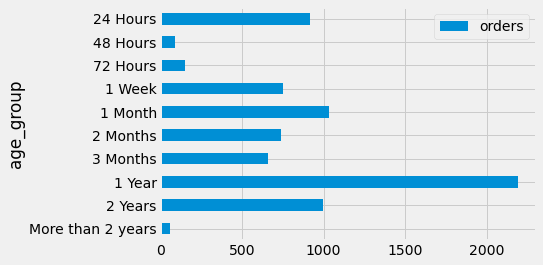

In [1463]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [1464]:
# Close connection
cnxn.close()